*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Loihi's learning engine in Lava

_**Motivation**: In this tutorial, we will demonstrate usage of a software model of Loihi's learning engine, exposed in Lava. This involves the LearningRule object for learning rule and other learning-related information encapsulation and the LearningConn Lava Process modelling learning-enabled connections._

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with the [ProcessModel concept in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

#### This tutorial gives a bird's-eye view of
- Loihi's learning engine
- how to define learning rules and other learning-related information
- how to instantiate and connect the learning-enabled connections LearningConn Process
- how to probe Vars **(currently a bit _hacky_)**

## Background

### Loihi's learning engine
Loihi provides a programmable learning engine that can evolve synaptic state variables over time as a function of several locally available parameters and the equations relating input terms to output synaptic target variables are called _learning rules_. These learning rule equations are highly configurable but are constrained to a sum of products form.

#### Epoch-based updates
For efficiency reasons, trace and synaptic variable updates proceed in learning epochs with a length of $t_{epoch}$ time steps. Within an epoch, spike events are recorded but trace and synaptic variable updates are only computed and applied with a slight delay at the end of the epoch. This delayed application will theoretically not have any impact as long as there is only one spike per synapse and per epoch.

#### Synaptic variables
For each synapse, Loihi's computational model defines a set of three synaptic state variables that can be modified by the learning engine. These are :
- Weight $W$, representing _synaptic efficacy_.
- Delay $D$, representing _synaptic delay_.
- Tag $T$, which is an additional synaptic variable that allows for constructing more complex learning dynamics.

#### Learning rules
The amount of change by which a target synaptic variable is updated at the end of a learning epoch is given by the learning rule associated with said variable. The rules are specified in sum-of-products form:

$$Z \in \{W, D, T\}$$

$$dZ = \sum_{i = 1}^{N_P} D_i \cdot \left[ S_i \cdot \prod_{j = 1}^{N_F^i} F_{i, j} \right]$$

The learning rule consists in a _sum_ of $N_P$ _products_. Each $i$'th product is composed of a dependency operator $D_i$, a scaling factor $S_i$ and a sub-product of $N_F^i$ factors with $F_{i, j}$ denoting the $j$'th factor of the current product.

#### Dependencies
Each product is associated with a _dependency_ operator $D_i$ that conditions the evaluation of a product on the presence of a pre- or post-synaptic spike during the past epoch or evaluates a product unconditionally every other epoch. $D_i$ also determines at what time step during an epoch, all trace variables in the associated product are evaluated. The table below lists the various dependency operators and their behavior:

| Dependency | $t_{eval}$ | Description |
| :- | :- | :- |
| $x_0$ | $t_x$ | Conditioned on at least one pre-synaptic spike during epoch. |
| $y_0$ | $t_y$ | Conditioned on at least one post-synaptic spike during epoch. |
| $u_{\kappa}$ | $t_{epoch}$ | Unconditionally executed every $\kappa \cdot t_{epoch}$ time steps. |

#### Scaling factors
Each product is also associated with a _scaling factor_ (constant literal) that is given in mantissa/exponent form :

$$S_i = S_i^{mant} \cdot 2^{S_i^{exp}}$$

#### Factors
Furthermore, Loihi provides a set of locally available quantities which can be used in learning rule to derive synaptic variable updates. The table below lists the various types of variables whose value $F_{i, j}$ can assume:

| Factor | Description |
| :- | :- |
| $$x_0 + C$$ | Pre-synaptic spike. |
| $$x_1(t_{eval}) + C$$ | Pre-synaptic trace $x_1$. |
| $$x_2(t_{eval}) + C$$ | Pre-synaptic trace $x_2$. |
| $$y_0 + C$$ | Post-synaptic spike. |
| $$y_1(t_{eval}) + C$$ | Post-synaptic trace $y_1$. |
| $$y_2(t_{eval}) + C$$ | Post-synaptic trace $y_2$. |
| $$y_3(t_{eval}) + C$$ | Post-synaptic trace $y_3$. |
| $$W + C$$ | Weight synaptic variable $W$. |
| $$D + C$$ | Delay synaptic variable $D$. |
| $$T + C$$ | Tag synaptic variable $T$. |
| $$sgn(W + C)$$ | Sign of $W$. |
| $$sgn(D + C)$$ | Sign of $D$. |
| $$sgn(T + C)$$ | Sign of $T$. |
| $$C$$ | Constant term _(variant 1)_. |
| $$C^{mant} \cdot 2^{C^{exp}}$$ | Constant term _(variant 2)_. |

#### Traces
Traces are low-pass filtered versions of spike train that are typically used in online implementations of [Spike-Timing Dependent Plasticity (STDP)](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity "Spike-Timing Dependent Plasticity"). For each synapse, Loihi provides a set of **2 pre-synaptic traces** $\{x_1, x_2\}$ and **3 post-synaptic traces** $\{y_1, y_2, y_3\}$. The dynamics of an ideal spike trace is given by :

$$z \in \{x_1, x_2, y_1, y_2, y_3\}$$

$$z(t) = z(t_{k-1}) \cdot exp(- \frac{t-t_{k-1}}{\tau^z}) + \xi^z \cdot \delta^{z}(t - t_k)$$

Here, the set $\{t_k\}$ are successive spike times at which the trace accumulates the spike impulse value $\xi^{z}$ while $\tau^z$ governs the speed of exponential decay between spike events. Finally, $\delta^z$ denotes the raw spike train associated with the trace $z$.

#### Example: Basic pair-based STDP

$$dW = S_1 \cdot x_0 \cdot y_1 + S_2 \cdot y_0 \cdot x_1$$

where $S_1 < 0$ and $S_2 > 0$.

## Tutorial
Now that we presented Loihi's learning engine, let us dive into demonstrating the several components exposing it to Lava in action. This involves :
- The **LearningRule** class/object, encapsulating learning rules and other learning-related information.
- The **LearningConn** Process, defining Vars for each of the quantities used by the learning engine (synaptic variables, dependencies, traces, within-epoch spike times).
- **LearningConn** ProcessModels, defining behavioral models for the LearningConn Process. These include:
    - LearningConn **PyFloatProcessModel** **_(used in this tutorial)_**: CPU behavioral implementation of Loihi 1’s learning engine in floating-point arithmetic.
    - LearningConn **PyFixedProcessModel**: CPU behavioral implementation of Loihi 1’s learning engine in fixed-point arithmetic.
    - LearningConn **NcProcessModel** _(WIP)_: Loihi behavioral implementation of Loihi 1’s learning engine.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

In [3]:
from procs.constant_pattern.process import ConstantPattern
from procs.poisson_rate_code_spike_gen.process import PoissonRateCodeSpikeGen
from procs.learning_dense_monitor.process import LearningDenseMonitor

from lava.proc.learning_rules.stdp_learning_rule import STDPLoihi
from lava.proc.dense.process import Dense, SignMode

### Parameters

In [4]:
SELECT_TAG = "floating_pt"

In [5]:
# Parameters

# Number of simulation time steps
num_steps = 500
time = list(range(1, num_steps + 1))

# ConstantPattern + PoissonRateSpikeGen + LIF shape (1 neuron)
shape = (1,)
# Connections shape (1 -> 1 neurons)
conn_shape = shape + shape

# Firing rate of pre-synaptic neuron
rate_pre = 0.04
# Firing rate of post-synaptic neuron
rate_post = 0.04

# Seeds for Poisson spike generation
seed_spike_gen_pre = 0
seed_spike_gen_post = 1

# LIF parameters
if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1

vth = 240

# PoissonRateSpikeGen -> LIF connection weight
wgt_sg_lif = 250
wgt_sg_lif_matrix = np.full(conn_shape, wgt_sg_lif)

# LIF -> LIF connection initial weight (learning-enabled)
wgt_pre_post = 50
wgt_pre_post_matrix = np.full(conn_shape, wgt_pre_post)

### Architecture
The following diagram depics the Lava Process architecture used in this tutorial. It consists of:
- 2 \[ _ConstantPattern_ + _PoissonRateSpikeGen_ + _Conn_ \] blocks for injection of rate coded spike trains generated by stochastic Poisson point-processes to LIF neurons.
- 2 _LIF_ Processes representing pre- and post-synaptic Leaky Integrate-and-Fire neurons.
- 1 _LearningConn_ Process representing learning-enable connection between LIF neurons.

>**Note:** 
All neuronal population (spike generator, LIF) are composed of only 1 neuron in this tutorial.

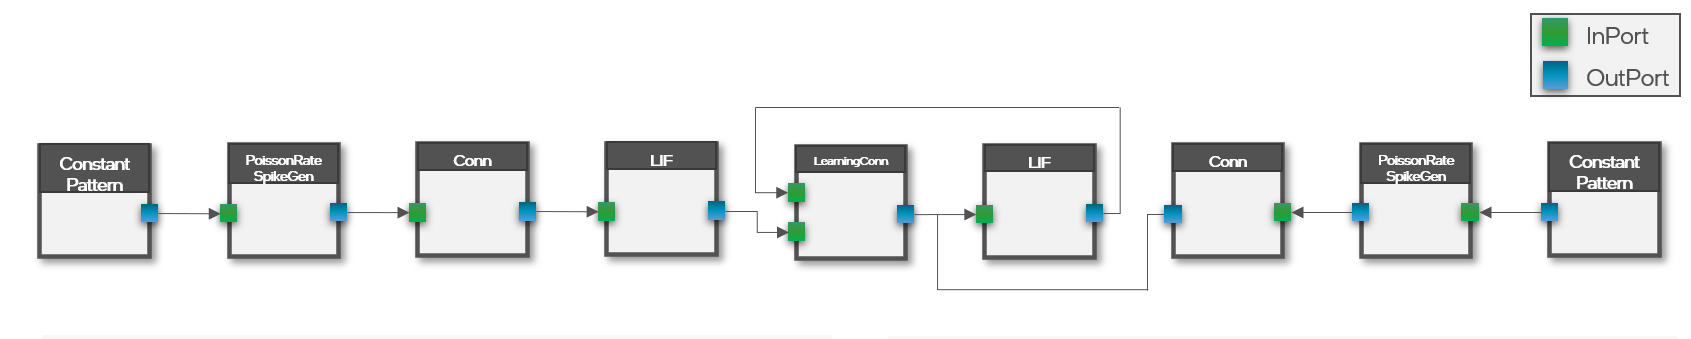

#### Instantiating Lava Processes
We begin by instantiating \[ ConstantPattern + PoissonRateSpikeGen + Conn \] blocks and LIF Processes.

In [6]:
# Instantiating Processes
pattern_pre = ConstantPattern(shape=shape, init_value=rate_pre)
spike_gen_pre = PoissonRateCodeSpikeGen(shape=shape, seed=seed_spike_gen_pre)
conn_sg_pre = Dense(weights=wgt_sg_lif_matrix)
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape)

pattern_post = ConstantPattern(shape=shape, init_value=rate_post)
spike_gen_post = PoissonRateCodeSpikeGen(shape=shape, seed=seed_spike_gen_post)
conn_sg_post = Dense(weights=wgt_sg_lif_matrix)
lif_post = LIF(u=0,
               v=0,
               du=du,
               dv=dv,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape)

#### Instantiating LearningRule

Next, we define a learning rule ($dw$) for the _weight_ synaptic variable. The learning rule is first written in string format and passed to the LearningRule object as instantiation argument. This string learning rule will get internally parsed, transformed into and stored as a _ProductSeries_, which is a custom data structure that is particularly well-suited for sum-of-products representation.

Here, we use the basic pair-based STDP learning rule defined by :

$$dw = -2 \cdot x_0 \cdot y_1 + 4 \cdot y_0 \cdot x_1$$

In [7]:
# Learning rule coefficient

on_pre_stdp = -2
on_post_stdp = 4

learning_rate = 1

# Trace decay constants
pre_tau = 10
post_tau = 10

# Epoch length
t_epoch = 1

As a reminder, the main function of the LearningRule object is not only to encapsulate learning rules, but also other learning-related such as trace impulse values and decay constants for all of the traces as well as the length of the learning epoch. The following table lists the different fields of the LearningRule class:

| Field | Python type | Description |
| :- | :- | :- |
| `dw` | ProductSeries | Learning rule targetting the synaptic variable $W$. |
| `dd` | ProductSeries | Learning rule targetting the synaptic variable $D$. |
| `dt` | ProductSeries | Learning rule targetting the synaptic variable $T$. |
| `x1_impulse` | float | Trace impulse value associated with $x_1$ trace. |
| `x1_tau` | int | Trace decay constant associated with $x_1$ trace. |
| `x2_impulse` | float | Trace impulse value associated with $x_2$ trace. |
| `x2_tau` | int | Trace decay constant associated with $x_2$ trace. |
| `y1_impulse` | float | Trace impulse value associated with $y_1$ trace. |
| `y1_tau` | int | Trace decay constant associated with $y_1$ trace. |
| `y2_impulse` | float | Trace impulse value associated with $y_2$ trace. |
| `y2_tau` | int | Trace decay constant associated with $y_2$ trace. |
| `y3_impulse` | float | Trace impulse value associated with $y_3$ trace. |
| `y3_tau` | int | Trace decay constant associated with $y_3$ trace. |
| `t_epoch` | int | Learning epoch length. |

In [8]:
# Instantiating LearningRule
learning_rule = STDPLoihi(learning_rate=learning_rate,
                          A_plus=on_pre_stdp,
                          A_minus=on_post_stdp,
                          tau_minus=pre_tau,
                          tau_plus=post_tau,
                          t_epoch=t_epoch)

#### Instantiating LearningConn Process
We now instantiate our LearningConn Process. This Process is a _connections_ Process that is similar to Conn Process, with the major difference being that learning (as defined by Loihi's learning engine) is enabled in the LearningConn Process.

The LearningConn Process takes the exact same instantiation parameters as the static Conn Process, along with a LearningRule object containing learning-related information. It also defines the same set of Ports and Vars as the Conn Process. However, to account for the several additional quantities defined by Loihi's learning, the LearningConn Process declares an additional set of Ports and Vars, which are listed in the table below:

| Component | Name | Description |
| :- | :- | :- |
| **InPort** | `s_in_bap` | Receives spikes from post-synaptic neurons.
| **Var** | `tag_2` | Delay synaptic variable.
|         | `tag_1` | Tag synaptic variable.
|         | `x0` | State of $x_0$ dependency.
|         | `tx` | Within-epoch spike times of pre-synaptic neurons.
|         | `x1` | State of $x_1$ trace.
|         | `x2` | State of $x_2$ trace.
|         | `y0` | State of $y_0$ dependency.
|         | `ty` | Within-epoch spike times of post-synaptic neurons.
|         | `y1` | State of $y_1$ trace.
|         | `y2` | State of $y_2$ trace.
|         | `y3` | State of $y_3$ trace.



In [9]:
# Instantiating LearningConn Process
conn_pre_post = Dense(weights=wgt_pre_post_matrix,
                      learning_rule=learning_rule,
                      sign_mode=SignMode.EXCITATORY)

#### Connecting Processes

In [10]:
# Connecting Processes
pattern_pre.a_out.connect(spike_gen_pre.a_in)
spike_gen_pre.s_out.connect(conn_sg_pre.s_in)
conn_sg_pre.a_out.connect(lif_pre.a_in)

pattern_post.a_out.connect(spike_gen_post.a_in)
spike_gen_post.s_out.connect(conn_sg_post.s_in)
conn_sg_post.a_out.connect(lif_post.a_in)

# Connecting LearningConn Process
lif_pre.s_out.connect(conn_pre_post.s_in)
conn_pre_post.a_out.connect(lif_post.a_in)

# bAP (back-propagating action potentials) connection: receives spikes from post-synaptic neurons
lif_post.s_out.connect(conn_pre_post.s_in_bap)

#### Setting probes (hack)

In [11]:
# Probes
monitor = LearningDenseMonitor(shape=conn_shape, buffer=num_steps)
# Probing pre-synaptic spikes
lif_pre.s_out.connect(monitor.s_pre_port)
# Probing post-synaptic spikes
lif_post.s_out.connect(monitor.s_post_port)
# Probing x1 trace
monitor.x1_port.connect_var(conn_pre_post.x1)
# Probing y1 trace
monitor.y1_port.connect_var(conn_pre_post.y1)
# Probing weights
monitor.weights_port.connect_var(conn_pre_post.weights)

### Running

In [12]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi1SimCfg(select_tag=SELECT_TAG))

/home/philipp/lava-nc-local/lava/src/lava/magma/core/model/py/connection.py:1170: RuntimeWarning: divide by zero encountered in divide
  return np.exp(-t / taus) * trace_values
/home/philipp/lava-nc-local/lava/src/lava/magma/core/model/py/connection.py:1170: RuntimeWarning: invalid value encountered in divide
  return np.exp(-t / taus) * trace_values


In [13]:
# Collecting probed data
spikes_data_pre = np.squeeze(monitor.s_pre.get(), axis=0)
spikes_pre = np.where(spikes_data_pre)[0]

spikes_data_post = np.squeeze(monitor.s_post.get(), axis=0)
spikes_post = np.where(spikes_data_post)[0]

x1_data = np.squeeze(monitor.x1.get(), axis=0)
y1_data = np.squeeze(monitor.y1.get(), axis=0)
wgt_data = np.squeeze(monitor.weights.get(), axis=(0, 1))

In [14]:
# Stopping
pattern_pre.stop()

### Results

#### Utility methods

In [15]:
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(15, 10))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.legend(spikes_plot, legend)
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=offsets)
    
    plt.show()
    
def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(15, 10))
    
    plt.step(time, time_series)
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    
    plt.show()
    
def extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt):
    # Compute the weight changes for every weight change event
    w_diff = np.zeros(wgt.shape)
    w_diff[1:] = np.diff(wgt)

    w_diff_non_zero = np.where(w_diff != 0)
    dw = w_diff[w_diff_non_zero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(time)
    t_non_zero = time[w_diff_non_zero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikes_pre = np.array(spikes_pre)
    spikes_post = np.array(spikes_post)
    dt = []
    for i in range(0, len(dw)):
        time_stamp = t_non_zero[i]
        t_post = (spikes_post[np.where(spikes_post <= time_stamp)])[-1]
        t_pre = (spikes_pre[np.where(spikes_pre <= time_stamp)])[-1]
        dt.append(t_post-t_pre)

    return np.array(dt), np.array(dw)
    
def plot_stdp(time, spikes_pre, spikes_post, wgt, 
              on_pre_stdp, y1_impulse, y1_tau, 
              on_post_stdp, x1_impulse, x1_tau):
    # Derive weight changes as a function of time differences
    diff_t, diff_w = extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt)
    
    # Derive learning rule coefficients
    on_pre_stdp = eval(str(on_pre_stdp).replace("^", "**"))
    a_neg = on_pre_stdp * y1_impulse
    on_post_stdp = eval(str(on_post_stdp).replace("^", "**"))
    a_pos = on_post_stdp * x1_impulse
    
    # Derive x-axis limit (absolute value)
    max_abs_dt = np.maximum(np.abs(np.max(diff_t)), np.abs(np.min(diff_t)))
    
    # Derive x-axis for learning window computation (negative part)
    x_neg = np.linspace(-max_abs_dt, 0, 1000)
    # Derive learning window (negative part)
    w_neg = a_neg * np.exp(x_neg / y1_tau)
    
    # Derive x-axis for learning window computation (positive part)
    x_pos = np.linspace(0, max_abs_dt, 1000)
    # Derive learning window (positive part)
    w_pos = a_pos * np.exp(- x_pos / x1_tau)
    
    plt.figure(figsize=(15, 10))
    
    plt.scatter(diff_t, diff_w, label="Weight changes", color="b")
    
    plt.plot(x_neg, w_neg, label="W-", color="r")
    plt.plot(x_pos, w_pos, label="W+", color="g")
    
    plt.title("STDP weight changes - Learning window")
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
    plt.legend()
    plt.grid()
    
    plt.show()

#### Spike trains

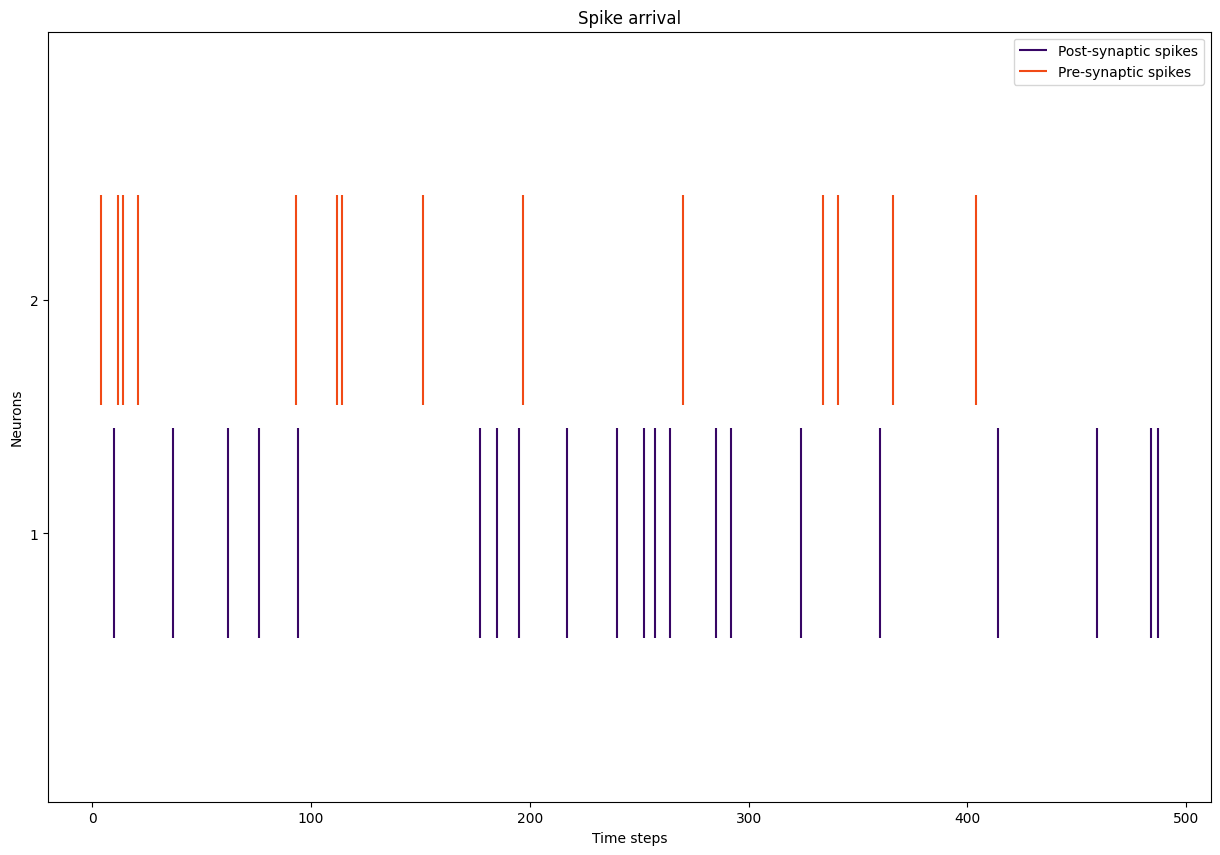

In [16]:
# Plotting pre- and post- spike arrival
plot_spikes(spikes=[spikes_post, spikes_pre], 
            legend=['Post-synaptic spikes', 'Pre-synaptic spikes'], 
            colors=['#370665', '#f14a16'])

#### Pre-synaptic trace x1

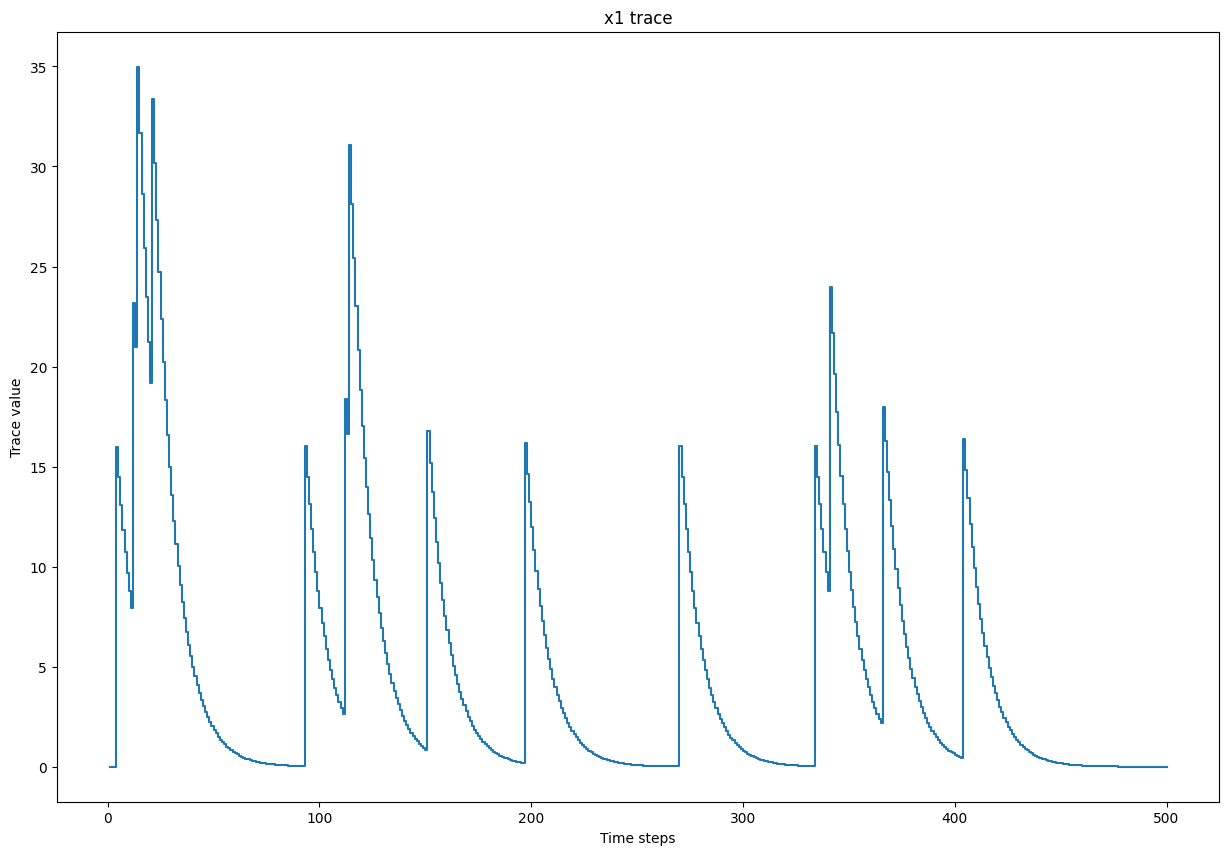

In [17]:
# Plotting x1 trace dynamics
plot_time_series(time=time, time_series=x1_data, ylabel="Trace value", title="x1 trace")

#### Post-synaptic trace y1

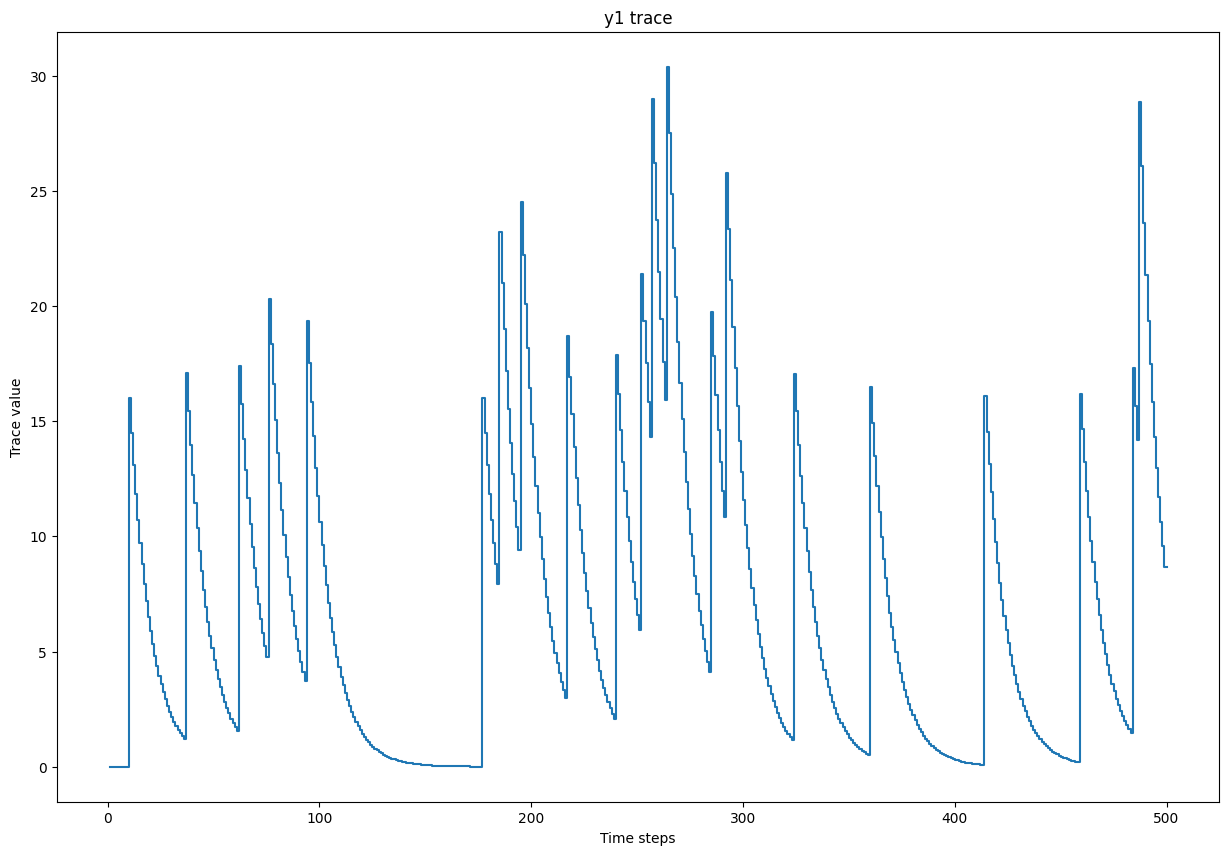

In [18]:
# Plotting y1 trace dynamics
plot_time_series(time=time, time_series=y1_data, ylabel="Trace value", title="y1 trace")

#### Weight W

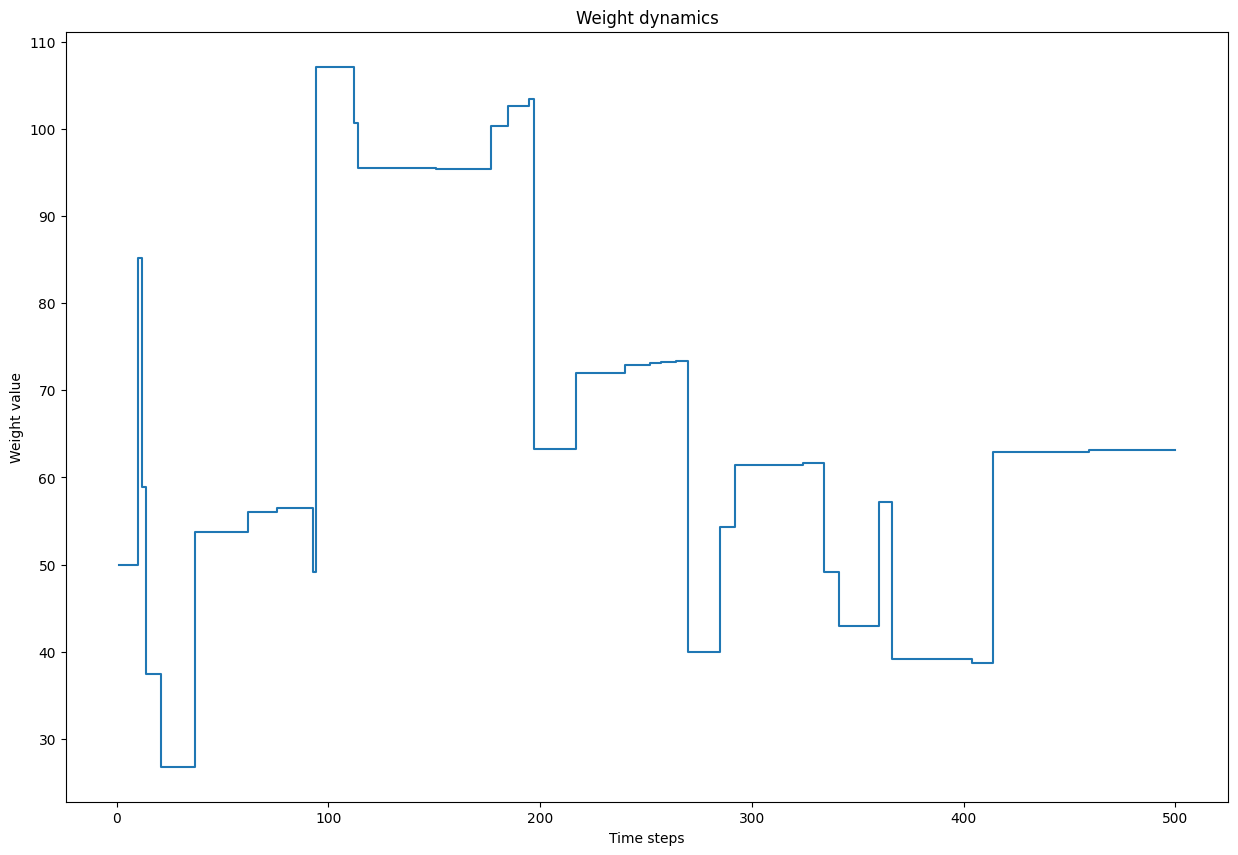

In [19]:
# Plotting weight dynamics
plot_time_series(time=time, time_series=wgt_data, ylabel="Weight value", title="Weight dynamics")

#### STDP learning window and weight changes

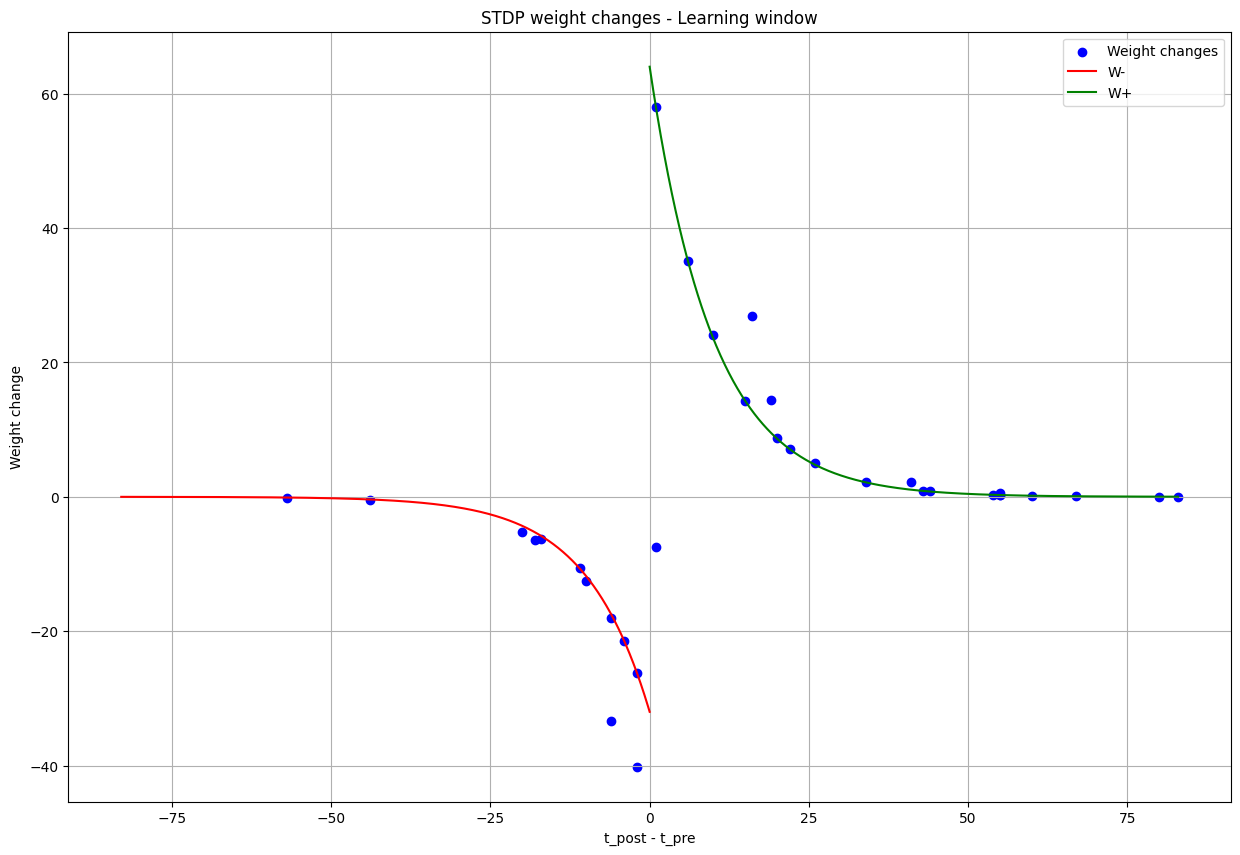

In [20]:
plot_stdp(time, spikes_pre, spikes_post, wgt_data, 
          on_pre_stdp, learning_rule.y1_impulse, post_tau, 
          on_post_stdp, learning_rule.x1_impulse, pre_tau)

### How to learn more?

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](../../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Connecting Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").